In [ ]:
!pip install scikit-survival lifelines

In [269]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from joblib import dump

In [270]:
DATASET_PATH = "paad_tcga_gdc_clinical_data"
MODEL_PATH = "model"

In [271]:
file_path = f"{DATASET_PATH}.tsv"
df = pd.read_csv(file_path, sep="\t")

display(df.head())

,Study ID,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Publication Version Type,Alcohol History Documented,Biopsy Site,Cancer Type,Cancer Type Detailed,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,Death from Initial Pathologic Diagnosis Date,Disease Free (Months),Disease Free Status,Disease Type,Ethnicity Category,Fraction Genome Altered,ICD-10 Classification,Is FFPE,Morphology,Mutation Count,Oncotree Code,Overall Survival (Months),Overall Survival Status,Other Patient ID,Other Sample ID,AJCC Pathologic M-Stage,AJCC Pathologic N-Stage,AJCC Pathologic Stage,AJCC Pathologic T-Stage,Primary Diagnosis,Patient Primary Tumor Site,Prior Malignancy,Prior Treatment,Project Identifier,Project Name,Project State,Race Category,Number of Samples Per Patient,Sample Type,Sample type id,Sex,Years Smoked,Person Cigarette Smoking History Pack Year Value,Patient's Vital Status,Year of Diagnosis
0,paad_tcga_gdc,TCGA-2J-AAB1,TCGA-2J-AAB1-01,65,7th,True,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,NaN,-23962,66.0,2.169839,0:DiseaseFree,Pancreas-Adenocarcinoma-Other Subtype,NaN,0.0620,C25.0,NO,8480/3,55.0,PAAD,2.168200,1:DECEASED,75119d1a-93e5-4ae7-9d60-69ee929a0772,b83d846d-1b92-430c-a98e-352fcd24c0ab,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma-Other Subtype,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,26.0,25.0,Dead,2012.0
1,paad_tcga_gdc,TCGA-2J-AAB4,TCGA-2J-AAB4-01,48,7th,False,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,729.0,-17794,NaN,23.966861,0:DiseaseFree,Pancreas-Adenocarcinoma-Other Subtype,NaN,0.1955,C25.8,NO,8140/3,26.0,PAAD,23.948752,0:LIVING,33833131-1482-42d5-9cf5-01cade540234,19110fc3-9693-4b22-ad08-3c06bcb33470,M0,N1,Stage IIB,T2,Pancreas-Adenocarcinoma-Other Subtype,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,NaN,NaN,Alive,2012.0
2,paad_tcga_gdc,TCGA-2J-AAB6,TCGA-2J-AAB6-01,75,7th,False,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,NaN,-27600,293.0,NaN,NaN,Pancreas-Adenocarcinoma Ductal Type,NaN,0.3519,C25.1,NO,8500/3,49.0,PAAD,9.625493,1:DECEASED,70797499-16e6-48cc-8ae4-1e692713dad3,75099a24-6487-4556-8893-249eb02e8c87,M0,N0,Stage IIA,T3,Pancreas-Adenocarcinoma Ductal Type,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,NaN,NaN,Dead,2012.0
3,paad_tcga_gdc,TCGA-2J-AAB8,TCGA-2J-AAB8-01,71,7th,False,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,80.0,-26028,NaN,NaN,NaN,Pancreas-Adenocarcinoma Ductal Type,NaN,0.0543,C25.0,NO,8500/3,40.0,PAAD,2.628121,0:LIVING,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,5f27b568-aa1b-4720-a176-f4a8c3fe7e40,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma Ductal Type,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,NaN,NaN,Alive,2012.0
4,paad_tcga_gdc,TCGA-2J-AAB9,TCGA-2J-AAB9-01,70,7th,True,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,NaN,-25920,627.0,17.128579,1:Recurred/Progressed,Pancreas-Adenocarcinoma Ductal Type,NaN,0.0038,C25.0,NO,8500/3,13.0,PAAD,20.597898,1:DECEASED,a5748656-5330-417a-8938-01f69ddb3576,02884cc4-f047-4d54-8389-b835e7707958,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma Ductal Type,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Female,NaN,NaN,Dead,2012.0


In [272]:
df = df.rename(columns={
    "Overall Survival (Months)": "duration",
    "Overall Survival Status": "event"
})

df["event"] = df["event"].str.contains("DECEASED").astype(int)

initial_rows = len(df)
df = df.dropna(subset=["duration", "event"])

In [273]:
leakage_cols = [
    "Death from Initial Pathologic Diagnosis Date",
    "Last Communication Contact from Initial Pathologic Diagnosis Date",
    "Disease Free (Months)",
    "Disease Free Status",
    "American Joint Committee on Cancer Publication Version Type",
    "Patient's Vital Status"
]
id_cols = ["Study ID", "Patient ID", "Sample ID", "Other Patient ID", "Other Sample ID"]

df = df.drop(columns=leakage_cols + id_cols, errors='ignore')

pd.set_option('display.max_columns', None)
display(df.head())

,Diagnosis Age,Alcohol History Documented,Biopsy Site,Cancer Type,Cancer Type Detailed,Birth from Initial Pathologic Diagnosis Date,Disease Type,Ethnicity Category,Fraction Genome Altered,ICD-10 Classification,Is FFPE,Morphology,Mutation Count,Oncotree Code,duration,event,AJCC Pathologic M-Stage,AJCC Pathologic N-Stage,AJCC Pathologic Stage,AJCC Pathologic T-Stage,Primary Diagnosis,Patient Primary Tumor Site,Prior Malignancy,Prior Treatment,Project Identifier,Project Name,Project State,Race Category,Number of Samples Per Patient,Sample Type,Sample type id,Sex,Years Smoked,Person Cigarette Smoking History Pack Year Value,Year of Diagnosis
0,65,True,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,-23962,Pancreas-Adenocarcinoma-Other Subtype,NaN,0.0620,C25.0,NO,8480/3,55.0,PAAD,2.168200,1,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma-Other Subtype,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,26.0,25.0,2012.0
1,48,False,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,-17794,Pancreas-Adenocarcinoma-Other Subtype,NaN,0.1955,C25.8,NO,8140/3,26.0,PAAD,23.948752,0,M0,N1,Stage IIB,T2,Pancreas-Adenocarcinoma-Other Subtype,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,NaN,NaN,2012.0
2,75,False,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,-27600,Pancreas-Adenocarcinoma Ductal Type,NaN,0.3519,C25.1,NO,8500/3,49.0,PAAD,9.625493,1,M0,N0,Stage IIA,T3,Pancreas-Adenocarcinoma Ductal Type,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,NaN,NaN,2012.0
3,71,False,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,-26028,Pancreas-Adenocarcinoma Ductal Type,NaN,0.0543,C25.0,NO,8500/3,40.0,PAAD,2.628121,0,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma Ductal Type,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Male,NaN,NaN,2012.0
4,70,True,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,-25920,Pancreas-Adenocarcinoma Ductal Type,NaN,0.0038,C25.0,NO,8500/3,13.0,PAAD,20.597898,1,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma Ductal Type,Pancreas,False,False,TCGA-PAAD,Pancreatic Adenocarcinoma,released,WHITE,1,Primary Tumor,1,Female,NaN,NaN,2012.0


In [274]:
initial_cols = len(df.columns)
df = df.dropna(axis=1, thresh=0.6 * len(df))
df = df.loc[:, df.nunique() > 1]

display(df.head())

,Diagnosis Age,Alcohol History Documented,Birth from Initial Pathologic Diagnosis Date,Disease Type,Ethnicity Category,Fraction Genome Altered,ICD-10 Classification,Morphology,Mutation Count,duration,event,AJCC Pathologic M-Stage,AJCC Pathologic N-Stage,AJCC Pathologic Stage,AJCC Pathologic T-Stage,Primary Diagnosis,Race Category,Number of Samples Per Patient,Sample Type,Sample type id,Sex,Year of Diagnosis
0,65,True,-23962,Pancreas-Adenocarcinoma-Other Subtype,NaN,0.0620,C25.0,8480/3,55.0,2.168200,1,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma-Other Subtype,WHITE,1,Primary Tumor,1,Male,2012.0
1,48,False,-17794,Pancreas-Adenocarcinoma-Other Subtype,NaN,0.1955,C25.8,8140/3,26.0,23.948752,0,M0,N1,Stage IIB,T2,Pancreas-Adenocarcinoma-Other Subtype,WHITE,1,Primary Tumor,1,Male,2012.0
2,75,False,-27600,Pancreas-Adenocarcinoma Ductal Type,NaN,0.3519,C25.1,8500/3,49.0,9.625493,1,M0,N0,Stage IIA,T3,Pancreas-Adenocarcinoma Ductal Type,WHITE,1,Primary Tumor,1,Male,2012.0
3,71,False,-26028,Pancreas-Adenocarcinoma Ductal Type,NaN,0.0543,C25.0,8500/3,40.0,2.628121,0,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma Ductal Type,WHITE,1,Primary Tumor,1,Male,2012.0
4,70,True,-25920,Pancreas-Adenocarcinoma Ductal Type,NaN,0.0038,C25.0,8500/3,13.0,20.597898,1,M0,N1,Stage IIB,T3,Pancreas-Adenocarcinoma Ductal Type,WHITE,1,Primary Tumor,1,Female,2012.0


In [275]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["duration", "event"]]

cat_cols = [c for c in df.select_dtypes(include="object").columns if c not in ["duration", "event"]]
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Combine equivalent diagnosis columns
df_encoded["Pancreas_Adenocarcinoma_Other"] = (
    df_encoded["Disease Type_Pancreas-Adenocarcinoma-Other Subtype"].fillna(0) |
    df_encoded["Primary Diagnosis_Pancreas-Adenocarcinoma-Other Subtype"].fillna(0)
).astype(int)

df_encoded["Pancreas_Colloid"] = (
    df_encoded["Disease Type_Pancreas-Colloid (mucinous non-cystic) Carcinoma"].fillna(0) |
    df_encoded["Primary Diagnosis_Pancreas-Colloid (mucinous non-cystic) Carcinoma"].fillna(0)
).astype(int)

df_encoded["Pancreas_Undifferentiated"] = (
    df_encoded["Disease Type_Pancreas-Undifferentiated Carcinoma"].fillna(0) |
    df_encoded["Primary Diagnosis_Pancreas-Undifferentiated Carcinoma"].fillna(0)
).astype(int)

# Drop the old redundant columns
df_encoded = df_encoded.drop(columns=[
    "Disease Type_Pancreas-Adenocarcinoma-Other Subtype",
    "Primary Diagnosis_Pancreas-Adenocarcinoma-Other Subtype",
    "Disease Type_Pancreas-Colloid (mucinous non-cystic) Carcinoma",
    "Primary Diagnosis_Pancreas-Colloid (mucinous non-cystic) Carcinoma",
    "Disease Type_Pancreas-Undifferentiated Carcinoma",
    "Primary Diagnosis_Pancreas-Undifferentiated Carcinoma"
], errors='ignore')

# Example: Combine AJCC staging (collapse detailed T/N/M into overall stage indicators)
df_encoded["AJCC_Stage_Advanced"] = (
    df_encoded.get("AJCC Pathologic Stage_Stage III", 0) +
    df_encoded.get("AJCC Pathologic Stage_Stage IV", 0)
).clip(upper=1)  # Stage III–IV as advanced disease

df_encoded["AJCC_Stage_Early"] = (
    df_encoded.get("AJCC Pathologic Stage_Stage IA", 0) +
    df_encoded.get("AJCC Pathologic Stage_Stage IB", 0)
).clip(upper=1)


display(df_encoded.head())

,Diagnosis Age,Birth from Initial Pathologic Diagnosis Date,Fraction Genome Altered,Mutation Count,duration,event,Number of Samples Per Patient,Sample type id,Year of Diagnosis,Alcohol History Documented_True,Ethnicity Category_NOT HISPANIC OR LATINO,ICD-10 Classification_C25.1,ICD-10 Classification_C25.2,ICD-10 Classification_C25.8,ICD-10 Classification_C25.9,Morphology_8140/3,Morphology_8246/3,Morphology_8255/3,Morphology_8480/3,Morphology_8500/3,AJCC Pathologic M-Stage_M1,AJCC Pathologic M-Stage_MX,AJCC Pathologic N-Stage_N1,AJCC Pathologic N-Stage_N1b,AJCC Pathologic N-Stage_NX,AJCC Pathologic Stage_Stage IA,AJCC Pathologic Stage_Stage IB,AJCC Pathologic Stage_Stage IIA,AJCC Pathologic Stage_Stage IIB,AJCC Pathologic Stage_Stage III,AJCC Pathologic Stage_Stage IV,AJCC Pathologic T-Stage_T2,AJCC Pathologic T-Stage_T3,AJCC Pathologic T-Stage_T4,AJCC Pathologic T-Stage_TX,Race Category_BLACK OR AFRICAN AMERICAN,Race Category_WHITE,Sample Type_Primary Tumor,Sex_Male,Pancreas_Adenocarcinoma_Other,Pancreas_Colloid,Pancreas_Undifferentiated,AJCC_Stage_Advanced,AJCC_Stage_Early
0,65,-23962,0.0620,55.0,2.168200,1,1,1,2012.0,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True,True,1,0,0,False,False
1,48,-17794,0.1955,26.0,23.948752,0,1,1,2012.0,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,True,1,0,0,False,False
2,75,-27600,0.3519,49.0,9.625493,1,1,1,2012.0,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,True,True,0,0,0,False,False
3,71,-26028,0.0543,40.0,2.628121,0,1,1,2012.0,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True,True,0,0,0,False,False
4,70,-25920,0.0038,13.0,20.597898,1,1,1,2012.0,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False,0,0,0,False,False


In [276]:
imputer = IterativeImputer(max_iter=20, random_state=42)
X = df_encoded.drop(columns=["duration", "event"])
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

display(X.head())

,Diagnosis Age,Birth from Initial Pathologic Diagnosis Date,Fraction Genome Altered,Mutation Count,Number of Samples Per Patient,Sample type id,Year of Diagnosis,Alcohol History Documented_True,Ethnicity Category_NOT HISPANIC OR LATINO,ICD-10 Classification_C25.1,ICD-10 Classification_C25.2,ICD-10 Classification_C25.8,ICD-10 Classification_C25.9,Morphology_8140/3,Morphology_8246/3,Morphology_8255/3,Morphology_8480/3,Morphology_8500/3,AJCC Pathologic M-Stage_M1,AJCC Pathologic M-Stage_MX,AJCC Pathologic N-Stage_N1,AJCC Pathologic N-Stage_N1b,AJCC Pathologic N-Stage_NX,AJCC Pathologic Stage_Stage IA,AJCC Pathologic Stage_Stage IB,AJCC Pathologic Stage_Stage IIA,AJCC Pathologic Stage_Stage IIB,AJCC Pathologic Stage_Stage III,AJCC Pathologic Stage_Stage IV,AJCC Pathologic T-Stage_T2,AJCC Pathologic T-Stage_T3,AJCC Pathologic T-Stage_T4,AJCC Pathologic T-Stage_TX,Race Category_BLACK OR AFRICAN AMERICAN,Race Category_WHITE,Sample Type_Primary Tumor,Sex_Male,Pancreas_Adenocarcinoma_Other,Pancreas_Colloid,Pancreas_Undifferentiated,AJCC_Stage_Advanced,AJCC_Stage_Early
0,65.0,-23962.0,0.0620,55.0,1.0,1.0,2012.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,48.0,-17794.0,0.1955,26.0,1.0,1.0,2012.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,75.0,-27600.0,0.3519,49.0,1.0,1.0,2012.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,71.0,-26028.0,0.0543,40.0,1.0,1.0,2012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,70.0,-25920.0,0.0038,13.0,1.0,1.0,2012.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [278]:
y = df_encoded[["duration", "event"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.concat([y_train, X_train], axis=1)
test_df = pd.concat([y_test, X_test], axis=1)

In [279]:
cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.75)
cph.fit(train_df, duration_col="duration", event_col="event")

train_cindex = cph.concordance_index_
test_pred = cph.predict_partial_hazard(test_df)
test_cindex = concordance_index(y_test["duration"], -test_pred, y_test["event"])

print(f"\nTrain C-index: {train_cindex:.3f}")
print(f"Test  C-index: {test_cindex:.3f}")


Train C-index: 0.670
Test  C-index: 0.630


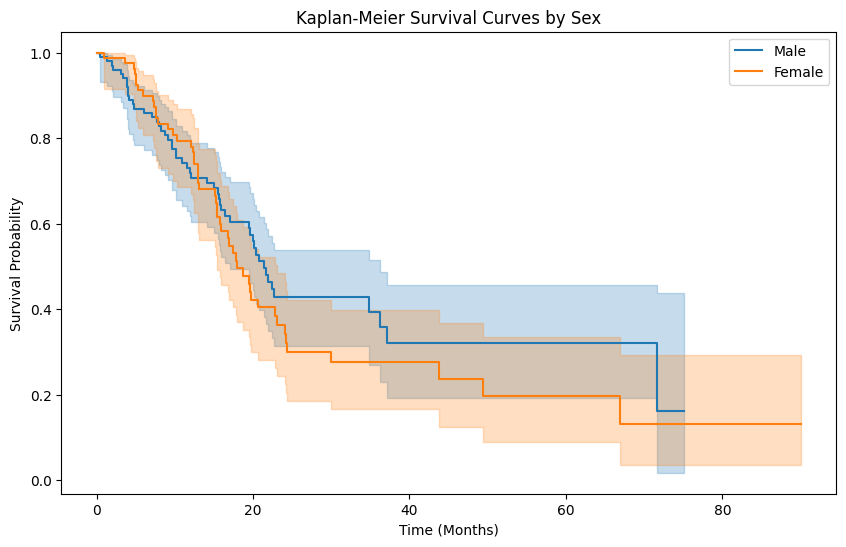

In [280]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for sex in df['Sex'].unique():
    group = df[df['Sex'] == sex]
    kmf.fit(group['duration'], event_observed=group['event'], label=sex)
    kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Sex')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [281]:
if not os.path.exists('bin'):
    os.makedirs('bin')
else:
  pass

dump(cph, f"bin/{MODEL_PATH}.joblib")


['bin/model.joblib']